In [137]:
from scipy import ndimage
from astropy.io import fits

In [138]:
import scipy.ndimage

In [139]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [140]:
from astropy.io import fits
import reproject
from astropy import convolution
from astropy.convolution import Gaussian2DKernel
from astropy import units as u
from astropy.table import Table
import pyavm

In [141]:
import regions
from astropy import coordinates

In [142]:
import PIL

In [143]:
from spectral_cube import SpectralCube, Projection, Slice

In [144]:
import uvcombine
from astropy import wcs

In [145]:
import matplotlib
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [146]:
import numpy as np

In [147]:
import pylab as pl
from astropy.visualization import simple_norm

In [148]:
basepath = '/orange/adamginsburg/jwst/brick'

In [149]:
img = fits.getdata(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)
header = fits.getheader(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)
ww = wcs.WCS(header)
img.shape

(2329, 5683)

In [150]:
img = fits.getdata(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits", ext=1)
header = fits.getheader(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits", ext=1)
ww = wcs.WCS(header)
img.shape

(4843, 11716)

In [151]:
import intake_astro
import intake_astro.array
import imp
imp.reload(intake_astro)
imp.reload(intake_astro.array)
from intake_astro.array import FITSArraySource

# Initial Experimentation

In [152]:
img.shape

(4843, 11716)

In [169]:
regs = regions.Regions.read(f'{basepath}/regions/bright_stars_short.reg')
if regs is not None:
    for reg in regs:
        preg = reg.to_pixel(ww)
        mask = preg.to_mask()
        slcs,smslcs = mask.get_overlap_slices(img.shape)
        img[slcs][mask.data.astype('bool')[smslcs]] = np.nan
img[img==0] = np.nan

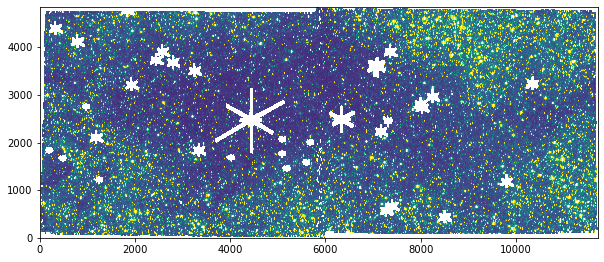

In [170]:
pl.imshow(img, vmin=-1, vmax=25)

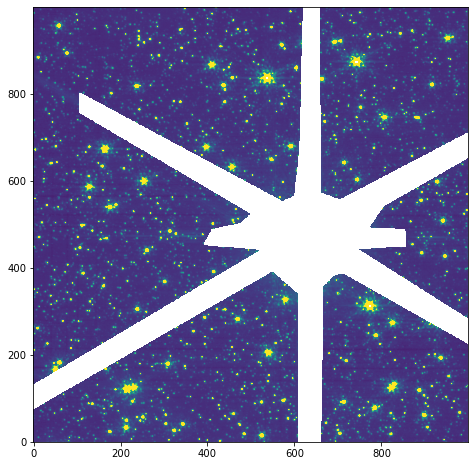

In [171]:
pl.imshow(img[2000:3000, 3800:4800], vmin=-1, vmax=25)

In [195]:
dx = 256
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

38

In [196]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

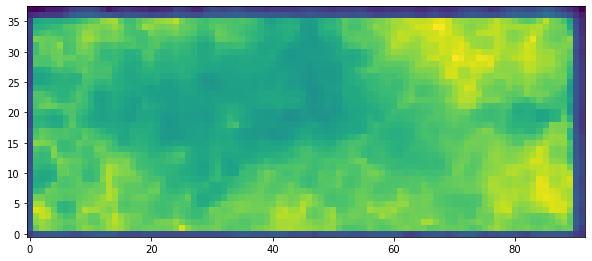

In [197]:
pl.imshow(arr)

In [198]:
dx = 128
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

76

In [199]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

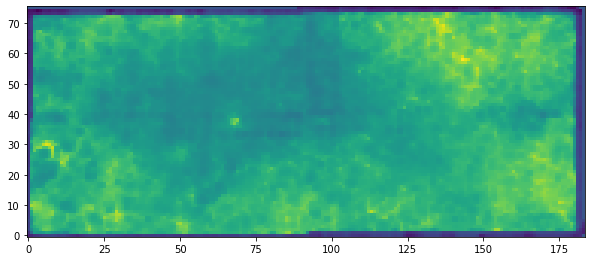

In [200]:
pl.imshow(arr)

In [201]:
dx = 64
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

152

In [202]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

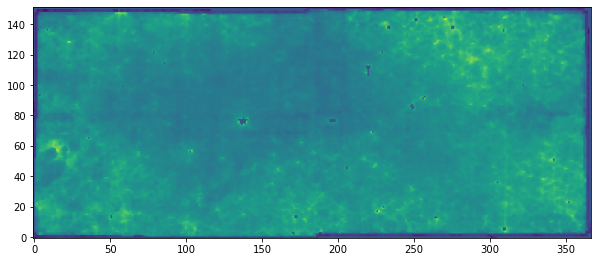

In [203]:
pl.imshow(arr)

In [204]:
dx = 32
chunks = [[img[(slice(sty, sty+dx), slice(stx, stx+dx))]
          for stx in range(0, img.shape[1], dx//2)]
          for sty in range(0, img.shape[0], dx//2)
         ]
len(chunks)

303

In [205]:
# only include positive values
arr = np.array(
    [[np.nanpercentile(ch, 1) if np.any(ch > 0) else 0
      for ch in row]
     for row in chunks]
)

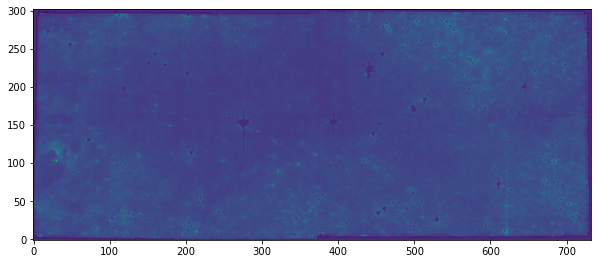

In [206]:
pl.imshow(arr)

# Deployment Version 

In [207]:
%run $basepath/reduction/destreak.py

<Figure size 720x576 with 0 Axes>

In [208]:
tp_410 = compute_zero_spacing_approximation(
    f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits", ext=1)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


In [209]:
tp_410.writeto(f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d_medfilt128.fits", overwrite=True)

In [210]:
import glob
import warnings
import regions

In [216]:
for fn in glob.glob(f'{basepath}/images/jw02221-o001_t001_nircam_*_i2d.fits'):
    with warnings.catch_warnings():
        # specifically ignoring that we're using non-integer 
        warnings.simplefilter('ignore')
        dx = 128 if 'f4' in fn else 256
        sl = 'long' if 'f4' in fn else 'short'
        regs = regions.Regions.read(f'{basepath}/regions/bright_stars_{sl}.reg')
        tp = compute_zero_spacing_approximation(fn, ext=1, dx=dx, regs=regs, percentile=10)
        if np.nanpercentile(tp.data, 10) < 0:
            print(np.nanpercentile(tp.data, 10))
            tp.data -= np.nanpercentile(tp.data, 10)
        tp.data[tp.data<0] = 0
        tp.writeto(fn.replace("_i2d.fits", f"_i2d_medfilt{dx}.fits"), overwrite=True)
        print(fn)
        print(fn.replace("_i2d.fits", f"_i2d_medfilt{dx}.fits"))

-1.095780050754547
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f212n_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f212n_i2d_medfilt256.fits
-1.999999713897705
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f187n_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f187n_i2d_medfilt256.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f410m_i2d_medfilt128.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_f405n-f444w_i2d_medfilt128.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f182m_i2d.fits
/orange/adamginsburg/jwst/brick//images/jw02221-o001_t001_nircam_clear-f182m_i2d_medfilt256.fits
/orange/adamginsburg/jwst/brick//images/jw02221

In [ ]:
filename = f"{basepath}//images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits"
ext = ('SCI', 1)

## Debugging the WCS

Each pixel is the median of 0:dx, dx/2:3dx/2, dx:2dx, ...

 * The center of the bottom-left pixel should be (0+dx) / 2 = dx/2
 * The center of the next pixel should be (dx/2 + 3dx/2) / 2 = dx
 * The center of the next pixel should be (dx + 2dx) / 2 = 3dx / 2

So why isn't that true except for the 2nd pixel?

In [ ]:
dx

In [ ]:
header = fits.getheader(filename, ext=ext)
ww = WCS(header)

wwsl = ww[dx//4+0.5::dx//2, dx//4+0.5::dx//2]

blc_1 = ww.pixel_to_world(dx//2, dx//2)
blc_2 = wwsl.pixel_to_world(0, 0)
print(f"BLC in original coords = pixel_to_world(dx/2, dx/2) = pixel_to_world ({dx//2,dx//2})= {blc_1}")
print(f"BLC in new coords = pixel_to_world(0, 0) = {blc_2}")
print(f"Separation: {blc_1.separation(blc_2).to(u.arcsec)}")
print()


blc_1b = ww.pixel_to_world(dx, dx)
blc_2b = wwsl.pixel_to_world(1, 1)
print(f"BLCb in original coords = pixel_to_world(dx, dx) = {blc_1b}")
print(f"BLCb in new coords = pixel_to_world(0, 0) = {blc_2b}")
print(f"Separation: {blc_1b.separation(blc_2b).to(u.arcsec)}")
print()


blc_1c = ww.pixel_to_world(dx*1.5, dx*1.5)
blc_2c = wwsl.pixel_to_world(2, 2)
print(f"BLCb in original coords = pixel_to_world(dx, dx) = {blc_1c}")
print(f"BLCb in new coords = pixel_to_world(0, 0) = {blc_2c}")
print(f"Separation: {blc_1b.separation(blc_2c).to(u.arcsec)}")


(
 wwsl.world_to_pixel(ww.pixel_to_world(0, 0)),
 wwsl.world_to_pixel(ww.pixel_to_world(dx//2, dx//2)),
 wwsl.world_to_pixel(ww.pixel_to_world(dx, dx)),
 wwsl.world_to_pixel(ww.pixel_to_world(1.5*dx, 1.5*dx)),
 dx//2)

In [ ]:
wwsl = ww[dx//4+1/2::dx//2, dx//4+1/2::dx//2]
crds_in = ww.pixel_to_world(np.arange(0, 256, 64), np.arange(0, 256, 64))
pix_out = wwsl.world_to_pixel(crds_in)
pix_out

In [ ]:
crds_in = ww.pixel_to_world(np.arange(1024), 64+np.zeros(1024))
crds_sl = wwsl.pixel_to_world(np.arange(16), np.zeros(16))
pl.plot(np.linspace(0,15,1024), crds_in.ra, label='in')
pl.plot(np.linspace(0,15,16), crds_sl.ra, label='sl')
pl.legend(loc='best');

In [ ]:
crds_in = ww.pixel_to_world(np.arange(512), np.zeros(512))
crds_sl = wwsl.pixel_to_world(np.arange(8), np.zeros(8))
pl.plot(np.linspace(0,7,512), crds_in.dec, label='in')
pl.plot(np.linspace(0,7,8), crds_sl.dec, label='sl')
pl.legend(loc='best');

In [ ]:
ww.pixel_to_world(*ww.wcs.crpix-1), ww.world_to_pixel_values(*ww.wcs.crval), ww.wcs.crpix-1

In [ ]:
wwsl.pixel_to_world(*wwsl.wcs.crpix-1), wwsl.world_to_pixel_values(*wwsl.wcs.crval), wwsl.wcs.crpix-1

In [ ]:
ww.pixel_to_world(*ww.wcs.crpix-1).separation(
    wwsl.pixel_to_world(*wwsl.wcs.crpix-1)
    )

In [ ]:
ww

In [ ]:
wwsl

In [ ]:
wwsl.wcs.cdelt / ww.wcs.cdelt

In [ ]:
for fn in glob.glob(f'{basepath}/images/jw02221-o001_t001_nircam_*_i2d.fits'):
    hdu = fits.open(fn)
    filtername = hdu[0].header['PUPIL']
    if filtername in ('CLEAR', 'F444W'):
        filtername = hdu[0].header['FILTER']
    print(fn, filtername)

In [ ]:
from scipy.ndimage import median_filter, map_coordinates